# Setup



In [0]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@7e06c968de3ec621c3ecae7bae28feaaaf70dad3
%pip install xlrd

In [0]:
%load_ext google.colab.data_table

In [0]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import warnings
import requests
from datetime import timedelta, date
from ergo.contrib.covid import brachbach, shaman, usafacts
from ergo.contrib.utils import plot_question, question, rejection_sample, sample_from_ensemble, samplers, summarize_question_samples, daterange

In [0]:
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

Select which county you are considering



In [0]:
#@title Enter County and State Here
county = "Orange County" #@param {type:"string"}
state = "NY" #@param {type:"string"}

# Retrieve external data and models



## Data



### Get cases data



Pulled from [here](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)



In [0]:
cases = usafacts.load_county_data(county, state)

### Access Data



In [0]:
def get_historical_data(date: date, column_name):
    """
    Look up the value of a parameter on a given date
    in the historical data we've loaded.

    Return the value or raise a KeyError if we don't have it.
    """

    # prefer usafacts data
    value = cases.loc[date, column_name]
    if np.isnan(value):
        raise KeyError(f"value for {column_name} in our historical data is NaN")
    return value

## Models



### Shaman et al. cases model



Pulled from [here](https://github.com/shaman-lab/COVID-19Projection)
([paper](https://www.medrxiv.org/content/10.1101/2020.03.21.20040303v2))



In [0]:
cu_projections = shaman.load_cu_projections(f"{county} {state}")

### @brachbach model: cases -> hospitalized



In [0]:
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed

# Model components



In this notebook, we model some aspects of how the COVID-19 pandemic will play out in
different counties across the US.

In this section, we model some key variables that we'll use to answer broader questions
in the next section. We sometimes ensemble multiple models to try to get a better
estimate of a variable.



In [0]:
START_DATE = date(2020, 4, 1)

## Daily COVID Infections



### Shaman Model



In [0]:
@ergo.mem
def cu_model_scenario():
    """Which of the model scenarios are we in?"""
    return ergo.random_choice([s for s in cu_projections.keys()])

@ergo.mem
def cu_model_quantile():
    """Where in the distribution of model outputs are we for this model run?
    Want to be consistent across time, so we sample it once per model run"""
    return ergo.uniform()

def cu_projection(param: str, date: date) -> int:
    """
    Get the Columbia model's prediction
    of the param for the date
    """
    scenario = cu_model_scenario()
    quantile = cu_model_quantile()

    # Extract quantiles of the model distribution
    xs = np.array([0.025, 0.25, 0.5, 0.75, 0.975])
    scenario_df = cu_projections[scenario]
    param_df = scenario_df[scenario_df["var"] == param]
    date_df = param_df[param_df["Date"] == date]
    if date_df.empty:
        raise KeyError(f"No Columbia project for param: {param}, date: {date}")

    ys = np.array(date_df[["2.5", "25",  "50",  "75",  "97.5"]].iloc[0])
    # Linearly interpolate
    return int(round(np.interp(quantile, xs, ys)))

### Get historical data or predict using ensemble



In [0]:
@ergo.mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        return get_historical_data(date, "cases")  # This works!
    except KeyError:  # if we don't have historical data, use our ensemble of models
        return sample_from_ensemble([
            lambda date: cu_projection("cases", date)    # we only have one model presently
        ], {"date": date}, [1], fallback=True, default=0)

## Daily COVID infections: mean, sma, peak



In [0]:
@ergo.mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

In [0]:
@ergo.mem
def sma_infections(date: date):
    """
    The simple moving average of infections for a date.

    Defined in https://pandemic.metaculus.com/questions/4128:

    'The 2-day SMA is defined as the unweighted average (arithmetic mean)
    over the current day and the previous day.'
    """
    return mean_infections(date - timedelta(1), date + timedelta(1))

@ergo.mem
def peak_compatible_with_historical_data(peak_date):
    """
    Check whether it's possible that some date in the past
    was the peak date of new COVID infections in El Paso,
    given the historical data we have about COVID infections
    """
    if not peak_date in cases.index:
        return True
    for comparison_date in daterange(START_DATE, peak_date + timedelta(11)):  #TODO refactor so as not reference a global here
        if comparison_date not in cases.index:
            continue
        if sma_infections(comparison_date) > sma_infections(peak_date):
            return False
        if sma_infections(comparison_date) == sma_infections(peak_date) and comparison_date > peak_date:
            return False
    return True


@ergo.mem
def peak_infection_date_community():
    """
    The community assigns probability to some dates in the past
    that we already know were not the peak.
    So instead of sampling from the full community distribution,
    sample from the portion of the community distribution
    that is plausibly correct.
    """    
    peak_date = rejection_sample(
        peak_infection_date.question.sample_community, 
        peak_compatible_with_historical_data)
    return peak_date

## Patients with COVID in the hospital



### @brachbach model+



In [0]:
br_confirmed_from_infected_model = get_daily_hospital_confirmed(cases, "cases", daily_infections)  # equating cases with hostpital confirmed, which is a hack to be replaced

def brachbach_model_plus(date: date) -> int:
    """
    Get a point estimate from @brachbach's model,
    then add some (fairly arbitrary) uncertainty
    """
    cases = br_confirmed_from_infected_model(date)

    if cases == 0:
      return cases
    cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
    return np.clip(cases_estimate, cases * 0.5, cases * 2)

### Get historical data or predict using ensemble



In [0]:
@ergo.mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        return get_historical_data(date, "In hospital confirmed")  # TODO find data for this
    except KeyError:  # if we don't have historical data, use our ensemble of models
        return sample_from_ensemble([
            lambda date: cu_projection("hosp", date), 
            brachbach_model_plus
        ], {"date": date}, [.2, .8], fallback=True, default=0)

## Proportion ICU admissions requiring ventilation



In [0]:
@ergo.mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

# determine what (if anything) we want here



## El Paso questions



,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,46.38,28.05,35.0,35.0,35.0,41.0,150.0


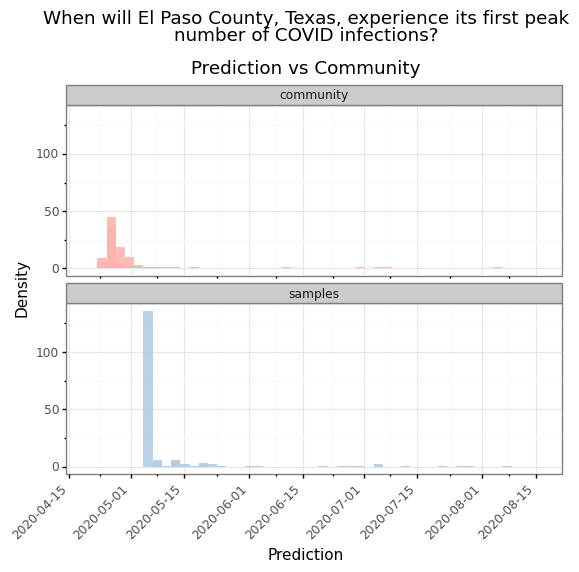

In [19]:
@question(metaculus, 4128, community_weight=0.3, community_fn=peak_infection_date_community, start_date=START_DATE)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?

    From https://pandemic.metaculus.com/questions/4128:
    'This question resolves as the date for which
    the 2-day simple moving average(SMA) of the number of reported new infections
    is strictly greater than the 2-day SMA over the subsequent 10 days.'
    """
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        sma_today = sma_infections(today)
        future_smas = [sma_infections(today + timedelta(i)) for i in range(1,11)]
        if sma_today > max(future_smas):
            return today
            return end_date

plot_question(peak_infection_date, start_date=START_DATE)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,101.0,47.5,31.73,35.0,35.00,35.00,35.0,153.0
peak_infections,200.0,3678.2,4477.67,0.0,70.14,85.76,9215.0,9215.0


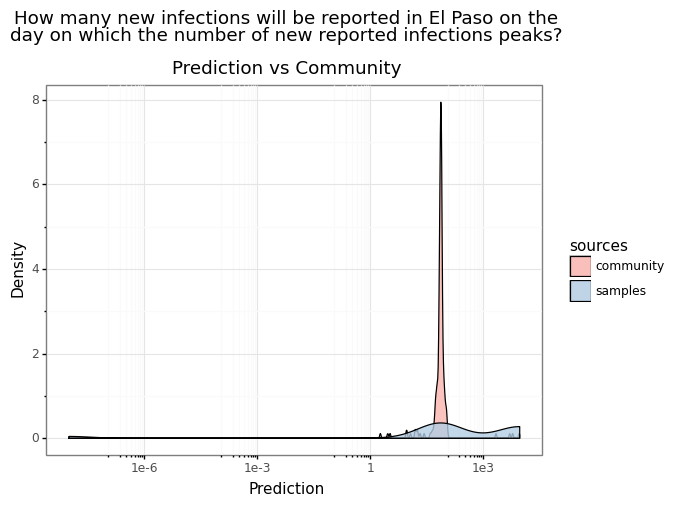

In [20]:
@question(metaculus, 4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)
plot_question(peak_infections)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,105.0,47.45,30.25,35.0,35.0,35.00,36.00,157.0
mean_infections_peak345,200.0,122.44,530.83,0.0,16.0,30.01,39.54,5191.6


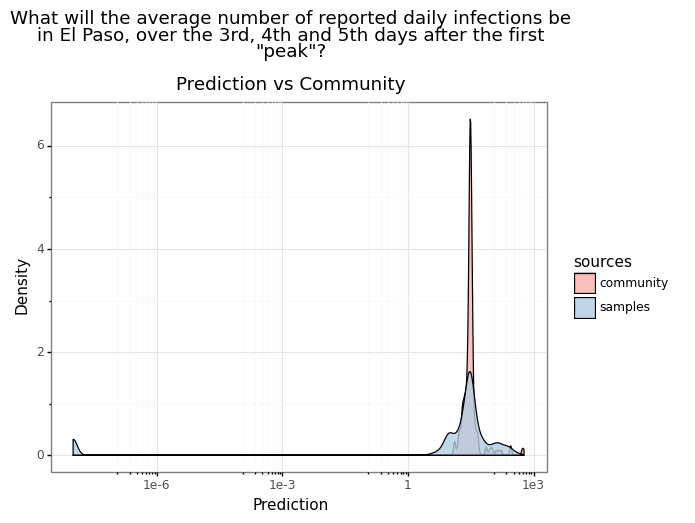

In [21]:
@question(metaculus, 4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))
plot_question(mean_infections_peak345)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,49.0,50.88,33.29,35.0,35.00,35.00,47.00,151.00
mean_infections_peak678,200.0,76.44,313.37,0.0,20.85,26.15,33.37,3020.81


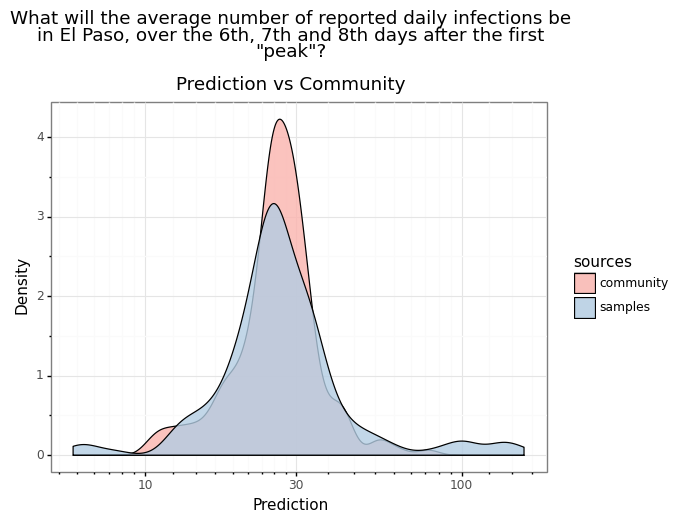

In [22]:
@question(metaculus, 4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))
plot_question(mean_infections_peak678)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,200.0,0.29,0.11,0.02,0.21,0.29,0.34,0.75


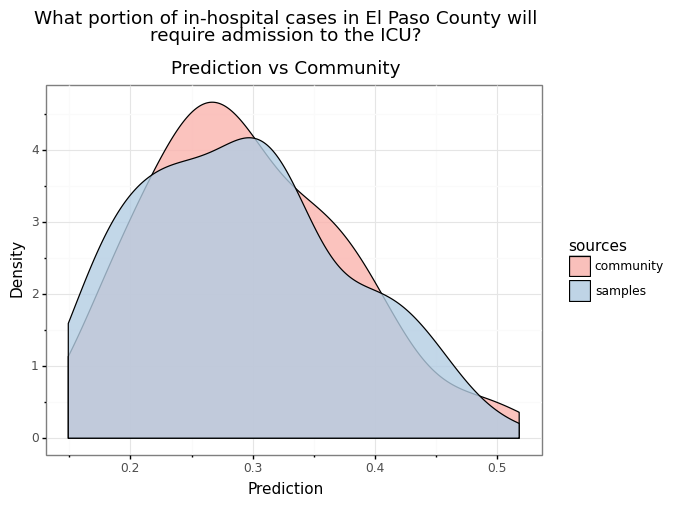

In [23]:
@question(metaculus, 4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])
plot_question(frac_patients_icu)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,140.0,0.30,0.10,0.02,0.23,0.30,0.37,0.68
frac_patients_invasive,200.0,0.16,0.06,0.01,0.11,0.15,0.19,0.36


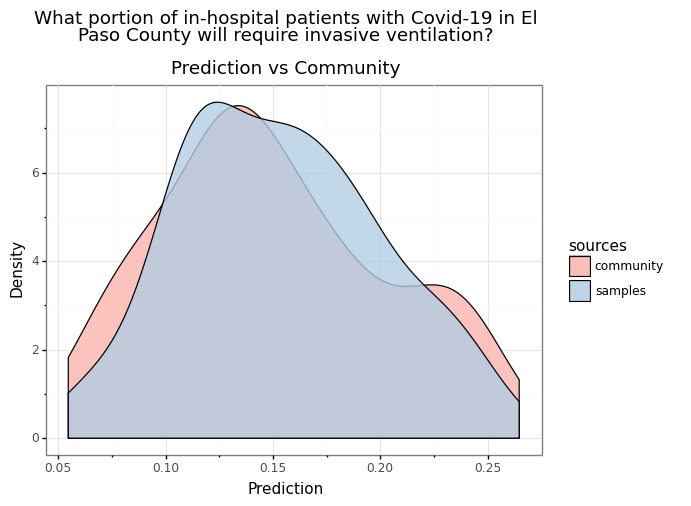

In [24]:
@question(metaculus, 4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()
plot_question(frac_patients_invasive)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,140.0,47.10,31.75,35.0,35.00,35.00,38.00,165.00
max_30d_hospital_confirmed_for_peak,200.0,6710.43,5219.49,0.0,75.53,10010.19,10919.88,13252.89


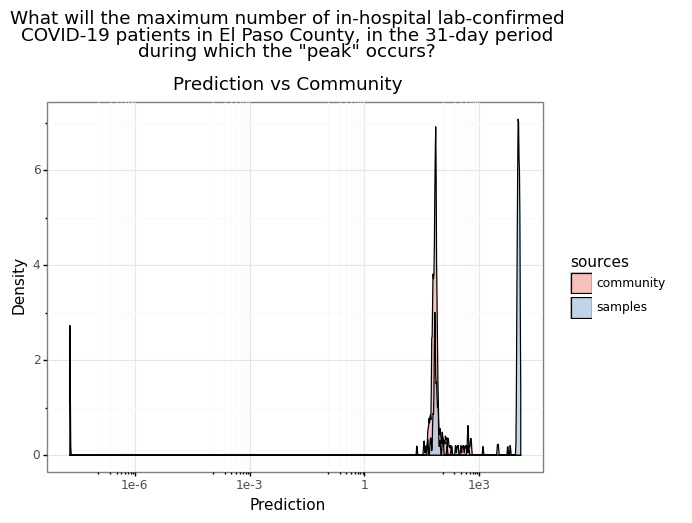

In [25]:
@ergo.mem
def peak_hospitalized_date():
    """
    What will be the date when there are the max number of COVID patients in the hospital
    within 15 days before or after the date of the first peak in confirmed cases?
    """
    infection_peak_date = peak_infection_date()
    days = list(daterange(infection_peak_date - timedelta(15), infection_peak_date + timedelta(16)))

    hospitalization_peak_date = days[0]
    hospitalized_peak = 0

    for day in days:
        hospitalized_for_day = hospital_confirmed_for_date(day)

        # if there are 2 different dates
        # with the same peak number of hospitalized patients,
        # return the first date:
        # https://pandemic.metaculus.com/questions/4204#comment-30023
        if hospitalized_for_day > hospitalized_peak:
            hospitalization_peak_date = day
            hospitalized_peak = hospitalized_for_day

    return hospitalization_peak_date

@question(metaculus, 4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    return hospital_confirmed_for_date(peak_hospitalized_date())

plot_question(max_30d_hospital_confirmed_for_peak, bw=0.01)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,47.58,29.94,35.00,35.00,35.00,39.25,161.00
peak_icu_patients,200.0,49.89,108.54,0.44,26.52,36.46,40.12,995.22


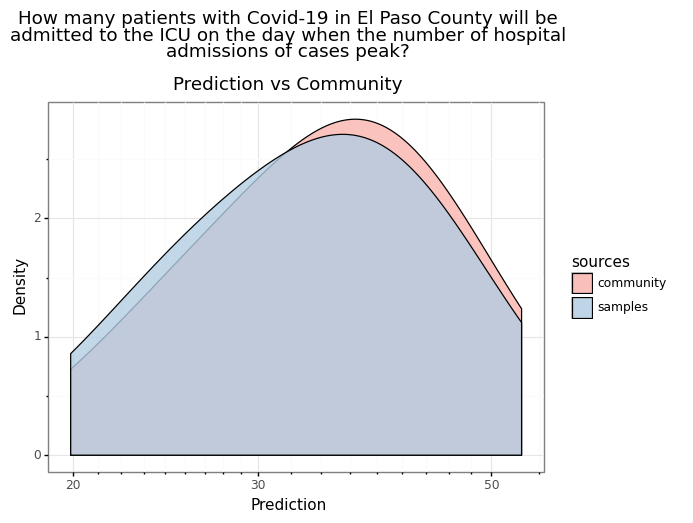

In [26]:
@question(metaculus, 4204)
def peak_icu_patients():
    """
    How many patients with Covid-19 in El Paso County will be in the
    ICU on the day when the number of hospital admissions of cases peak? 
    """
    peak_date = peak_hospitalized_date()

    try:
        return get_historical_data(peak_date, "in_icu")  # TODO find data for this
    # if we don't have historical data, sample from the Columbia model or from the community
    except KeyError:
        return sample_from_ensemble([
            lambda date: cu_projection("ICU", date), 
            lambda date: peak_icu_patients.question.sample_community()
        ], {"date": date}, [.65, .35], fallback=True)
plot_question(peak_icu_patients, bw=0.1)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,48.50,30.27,35.00,35.00,35.00,41.00,158.00
peak_invasive_ventilation,200.0,36.12,36.39,0.93,25.69,34.21,40.12,511.73


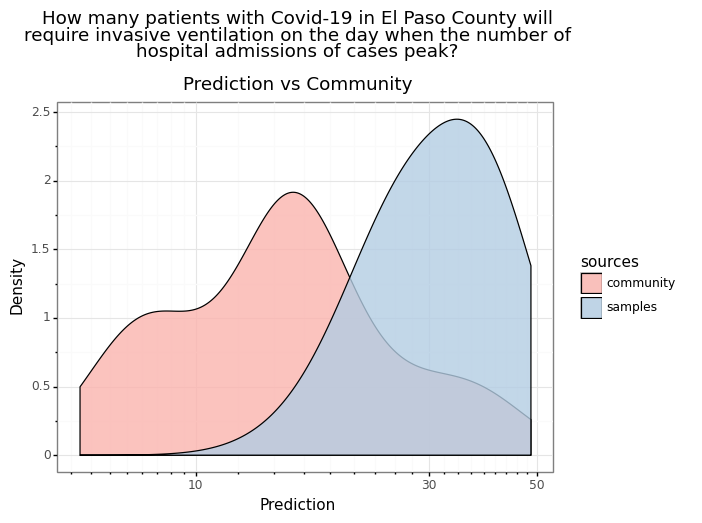

In [27]:
@question(metaculus, 4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will be on invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?
    """
    try:
        return get_historical_data(peak_hospitalized_date(), "on_ventilator")  # TODO find data for this
    # if we don't have historical data, sample from the Columbia model or from the community
    except KeyError:
        return sample_from_ensemble([
            lambda date: cu_projection("ICU", date), 
            lambda date: peak_icu_patients.question.sample_community()
        ], {"date": date}, [.65, .35], fallback=True)


plot_question(peak_invasive_ventilation, bw=0.1)